# OpSim -- the updated simulation notebook

## About

This notebook is running the LuSEE-Night simulations, as a part of "Conops" R&D. Notes:
* Celestial bodies: data is read from prefabricated files in HDF5 format, containing the pre-calculated Sun and the two Satellites' positions as time series.
* The time axis in the time series is defined in units of _MJD_
* The _lunar clock_ is an auxiliary variable which defines a "lunar day" as 24 "lunar hours", used mainly to refer to the temperature data obtained from the __Diviner__


In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import  os, sys
import  matplotlib.pyplot as plt

sys.path.append('../')  # Add parent dir to path

# ---------------------------------------------------------
import  lusee        # Core lusee software
from    nav import * # Astro/observation wrapper classes
from    utils.timeconv import *

In [2]:
import  sim # Main simulation module, which contains the Simulator class
from    sim import Simulator

chatty = False
if chatty:
    print("---------------------------------- PATH ----------------------------------------")
    for path_part in sys.path:
        if path_part!='': print(f'''{path_part}''')

    print('--------------------------------- VERSIONS -------------------------------------')
    print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

# Define paths in one place:
orbitals    = "../data/orbitals/20260110-20270115.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"

#comtable    = "../config/comtable-20260110-20270115.yml"
#comtable    = "./simulator_log.yml"
comtable = None

initial_time=2
until=4600
#2780

smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until, verbose=True)

mjd_start   = smltr.sun.mjd[initial_time]
mjd_end     = smltr.sun.mjd[until]

if chatty:
    print(f'''Initial time in ticks: {initial_time}, mjd: {mjd_start}, datetime: {mjd2dt(mjd_start)}, Sun Alt: {smltr.sun.alt[initial_time]}''')
    print(f'''Until time in ticks: {until}, mjd: {mjd_end}, datetime: {mjd2dt(mjd_end)}''')
    print(smltr.schedule)


Shape of the data payload: (35450, 7)
Created a Battery with initial charge: 432000.0, capacity: 862098.3468
Created a SSD with initial fill: 0.0, capacity: 32000000.0
Lander pitch, roll, yaw: [0. 0. 0.]
Adding panel EPanel with normal [1. 0. 0.], 	efficiency 0.9, and surface area 0.1565
Adding panel WPanel with normal [-1.  0.  0.], 	efficiency 0.9, and surface area 0.1565
Adding panel TPanel with normal [0. 0. 1.], 	efficiency 0.9, and surface area 0.313


In [3]:
smltr.power_info()

Mode:  science
     Device: PDU          : 0.90 W
     Device: HEATER       : 0.00 W
     Device: DCB          : 2.00 W
     Device: UT           : 0.00 W
     Device: spectrometer : 11.50 W
     Device: PFPS         : 7.48 W
     Device: PCDU         : 0.80 W
     Device: preamp       : 0.90 W
   Total power: 23.6 W

Mode:  maint
     Device: PDU          : 0.90 W
     Device: HEATER       : 0.00 W
     Device: DCB          : 2.00 W
     Device: UT           : 5.30 W
     Device: spectrometer : 0.00 W
     Device: PFPS         : 2.30 W
     Device: PCDU         : 1.50 W
     Device: preamp       : 0.90 W
   Total power: 12.9 W

Mode:  powersave
     Device: PDU          : 0.90 W
     Device: HEATER       : 1.00 W
     Device: DCB          : 2.00 W
     Device: UT           : 0.00 W
     Device: spectrometer : 0.00 W
     Device: PFPS         : 2.30 W
     Device: PCDU         : 0.80 W
     Device: preamp       : 0.90 W
   Total power:  7.9 W



---

Visualize power consumption for each device, in different modes, in a bar chart (optional)

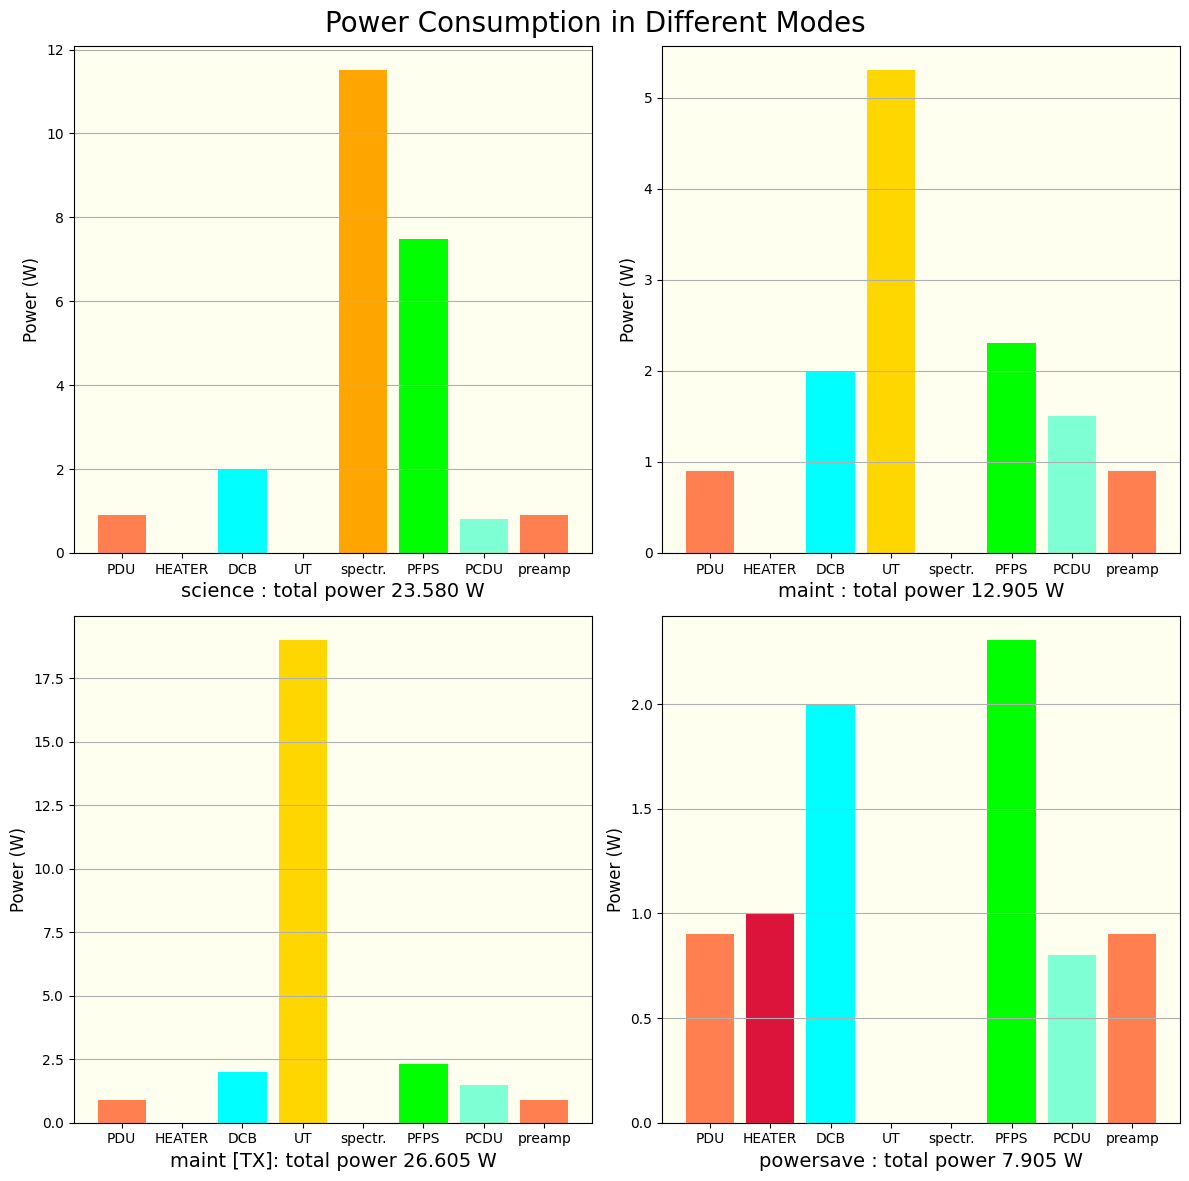

In [24]:
pwr_science = smltr.power_out(mode='science', return_dict=True)
device_names = list(pwr_science.keys())

for i in range(len(device_names)):
    if device_names[i]=='spectrometer':
        device_names[i]='spectr.'


fig, plots = plt.subplots(2,2, figsize=(12,12))
fig.suptitle('Power Consumption in Different Modes', fontsize=20)
plt.rcParams["figure.figsize"] = [18., 6.]

clrs = ["coral","crimson", "cyan", "gold", "orange", "lime", "aquamarine"]

mode_list = [('science',[]), ('maint',[]), ('maint',['TX']), ('powersave',[])]
for i,mode_pair in enumerate(mode_list):
    mode, cond = mode_pair
    pwr = list(smltr.power_out(mode = mode, conditions = cond, return_dict=True).values())
    plots[i//2][i%2].bar(device_names, pwr, color=clrs,   label="Science")
    total_power = 0.0
    for device_power in pwr: total_power+=device_power
    tx = '[TX]' if 'TX' in cond else ''
    xlabel = f'{mode} {tx}: total power {total_power:.3f} W'
    plots[i//2][i%2].set_xlabel(xlabel, fontsize=14)

for l in plots:
    for p in l:
        p.set_ylabel('Power (W)', fontsize=12)
        p.grid(axis='y')
        p.set_facecolor('ivory')


---

### Run the simulation

In [5]:
# Set verbose if needed:
smltr.verbose = False # True
smltr.simulate(create_command_table=True)
comtable = '/tmp/current-command-table.yml'
smltr.save_record(comtable)


In [6]:
## now run again with generated command table
comtable = '/tmp/current-command-table.yml'
smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until)
smltr.verbose = False # True
smltr.simulate()

---

### Plot the results

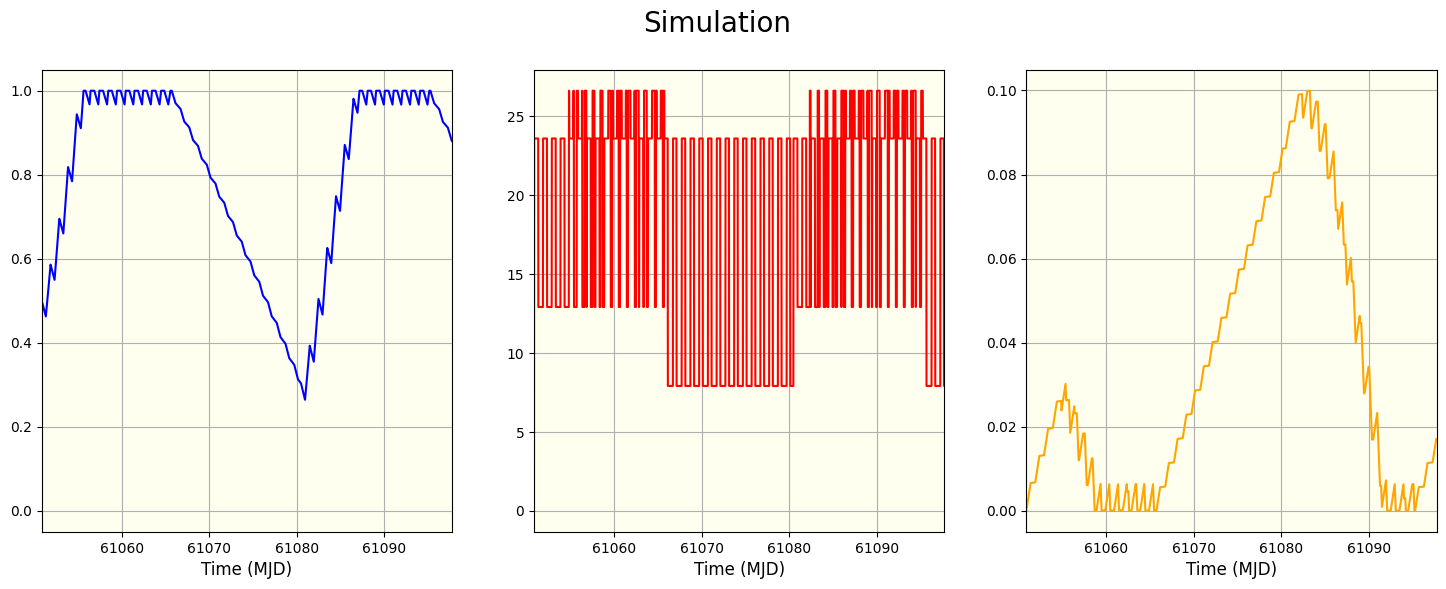

In [7]:
mjd = smltr.sun.mjd

fig, plots = plt.subplots(1,3, figsize=(18,6))

fig.suptitle('Simulation', fontsize=20)

plt.rcParams["figure.figsize"] = [18., 6.]
plt.rcParams["figure.autolayout"] = True


ylabels = ['Battery Charge', 'Current drawn by the hardware', 'Data volume stored in SSD']
colors  = ["blue", "red", "orange"]
data    = (smltr.monitor.battery_SOC, smltr.monitor.power, smltr.monitor.ssd)

mjd = smltr.sun.mjd

xlo = mjd[smltr.initial_time]
xhi = mjd[smltr.until] - 1

for i in range(3):
    p = plots[i]

    p.plot(mjd, data[i], color=colors[i],   label=ylabels[i])
    p.set_xlabel('Time (MJD)', fontsize=12)
    p.set_xlim([xlo, xhi])
    p.grid(True)
    p.set_facecolor('ivory')

plt.show()





---

### Optional -- some graphs.



35450


(61110.0, 61114.0)

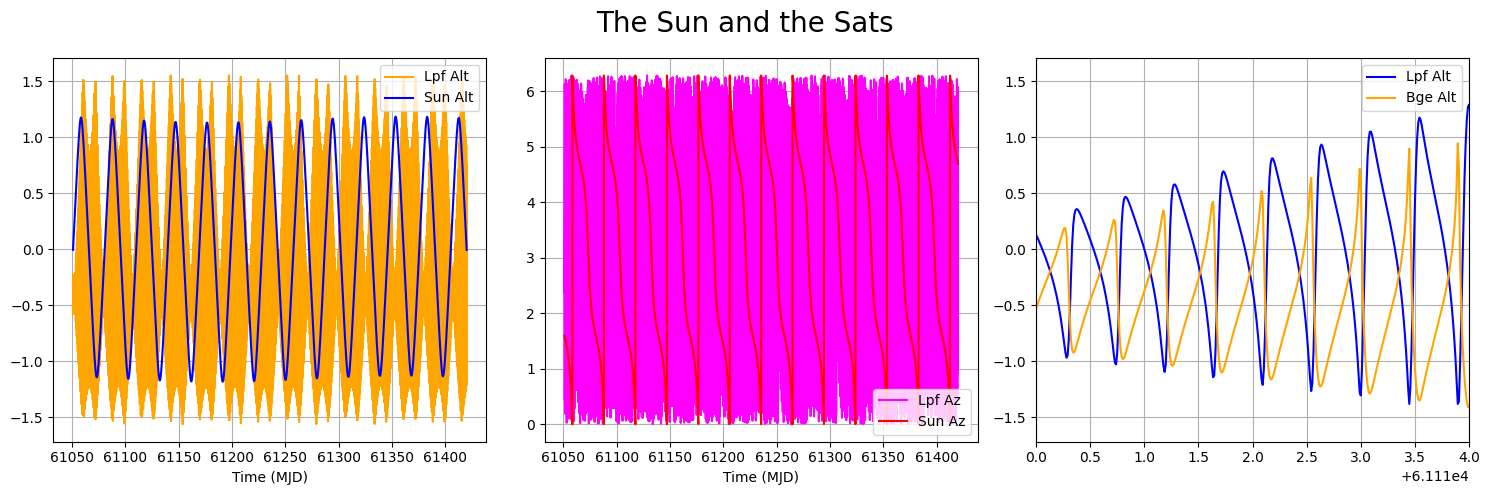

In [8]:
# OPTIONAL PLOTS

plt.rcParams["figure.figsize"] = [15., 5.]

# Get a handle on the sun and the satellite, in case needed for diagnostics
mySun = smltr.sun
myLpf = smltr.lpf
myBge = smltr.bge

print(mySun.N)

fig, (p1, p2, p3) = plt.subplots(1,3)

fig.suptitle('The Sun and the Sats', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(myLpf.mjd, myLpf.alt,  color="orange", label="Lpf Alt")
p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")

p2.plot(myLpf.mjd, myLpf.az, color="magenta",label="Lpf Az")
p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")


p3.plot(myLpf.mjd, myLpf.alt,  color="blue", label="Lpf Alt")
p3.plot(myBge.mjd, myBge.alt,  color="orange", label="Bge Alt")

p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()

p3.grid(True)
_ = p3.legend()
p3.set_xlim(61110,61114)

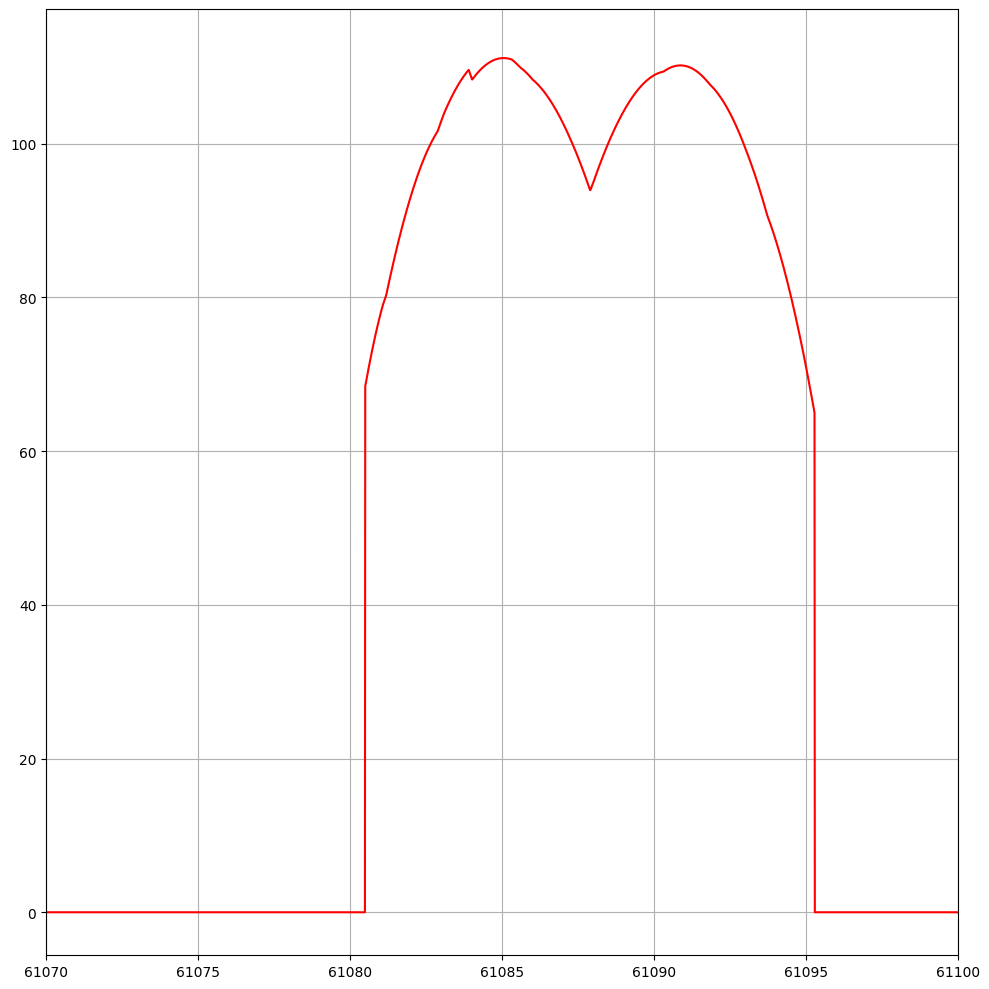

In [9]:
# OPTIONAL


plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, smltr.controller.power,  color="red",    label="Panel power*100")
plt.xlim(61070, 61100)
ax.grid(True)
